# Training on 13,231 events from ACTS. Testing on 3308 events from ACTS.

In [ ]:
!nvidia-smi

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import keras
import sys
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker import extractor as ext, utils, metrics, visuals

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0E:00.0)


### Load in the data.

In [2]:
%%time
frame = pd.read_csv("data/sets/ACTS-MU2000-EV1000.gz")

CPU times: user 13.9 s, sys: 408 ms, total: 14.3 s
Wall time: 14.3 s


In [3]:
frame.rename(columns = {'barcode':'cluster_id'}, inplace = True)
frame

,Unnamed: 0,Unnamed: 0.1,event_id,cluster_id,phi,r,z,momentum,charge
0,0,23892,1,206158430208,1.951472,31.959915,140.5190,3.990610,-1
1,1,23894,1,206158430208,1.970991,71.842854,391.8060,3.990610,-1
2,2,831,1,274877906944,-2.097345,31.959915,-272.7190,7.700080,1
3,3,6708,1,343597383680,2.798524,31.959915,-118.7530,1.525380,-1
4,4,6710,1,343597383680,2.816034,71.842854,-199.3280,1.525380,-1
5,5,6711,1,343597383680,2.835049,115.820868,-285.3840,1.525380,-1
6,6,6712,1,343597383680,2.859102,171.805097,-394.5950,1.525380,-1
7,7,4711,1,1236950581248,2.740044,31.959915,-138.3000,2.658580,-1
8,8,4712,1,1236950581248,2.752914,71.842854,-241.1750,2.658580,-1
9,9,4714,1,1236950581248,2.766501,115.820868,-355.4480,2.658580,-1


In [5]:
%%time
frame = ext.prepare_frame(frame, n_tracks=3650, n_rows=11650, n_noise=0)

CPU times: user 30.8 s, sys: 492 ms, total: 31.3 s
Wall time: 31.3 s


In [7]:
frame.to_csv("data/sets/ACTS-MU2000-EV1000-PREPARED.gz", compression="gzip")

In [8]:
%%time
modelpath = "data/models/ACTS-MU2000-1000E.h5"
filepath  = "data/sets/ACTS-MU2000-EV1000-PREPARED.gz"
frame     = pd.read_csv(filepath)
events    = [event for (_, event) in frame.groupby("event_id", sort=False)]
percent   = 0.8
cutoff    = int(percent * len(events))
train, test = events[:cutoff], events[cutoff:]
print("Train is list of {} events.".format(len(train)))
print("Test is list of {} events.".format(len(test)))
print("Train takes up {} bytes.".format(sys.getsizeof(train)))
print("Test takes up {} bytes.".format(sys.getsizeof(test)))
if (not utils.is_prepared(train[0])) or (not utils.is_prepared(test[0])):
    print("Warning: frame is not prepared.")
    print("Look at the prepare_frame() function in tracker/extractor.py")
else:
    del events

Train is list of 800 events.
Test is list of 200 events.
Train takes up 6464 bytes.
Test takes up 1664 bytes.
CPU times: user 14.8 s, sys: 596 ms, total: 15.4 s
Wall time: 15.3 s


In [9]:
order = ["phi", "r", "z"]

### Get an idea for how the tracks are distributed among the events.

In [10]:
dist = metrics.distributions(pd.concat(train))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

There are 2 events with 253 tracks.
There are 1 events with 1610 tracks.
There are 1 events with 1620 tracks.
There are 1 events with 1660 tracks.
There are 1 events with 1661 tracks.
There are 1 events with 1758 tracks.
There are 2 events with 1794 tracks.
There are 1 events with 1795 tracks.
There are 1 events with 1828 tracks.
There are 1 events with 1860 tracks.
There are 1 events with 1861 tracks.
There are 2 events with 1878 tracks.
There are 1 events with 1880 tracks.
There are 1 events with 1884 tracks.
There are 1 events with 1895 tracks.
There are 1 events with 1902 tracks.
There are 1 events with 1910 tracks.
There are 1 events with 1929 tracks.
There are 1 events with 1940 tracks.
There are 1 events with 1942 tracks.
There are 1 events with 1943 tracks.
There are 1 events with 1944 tracks.
There are 1 events with 1949 tracks.
There are 1 events with 1952 tracks.
There are 1 events with 1955 tracks.
There are 1 events with 1962 tracks.
There are 1 events with 1963 tracks.
Th

In [11]:
dist = metrics.distributions(pd.concat(test))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

There are 1 events with 1724 tracks.
There are 1 events with 1751 tracks.
There are 1 events with 1803 tracks.
There are 1 events with 1853 tracks.
There are 1 events with 1872 tracks.
There are 1 events with 1889 tracks.
There are 1 events with 1899 tracks.
There are 1 events with 1929 tracks.
There are 1 events with 1937 tracks.
There are 1 events with 2021 tracks.
There are 1 events with 2026 tracks.
There are 1 events with 2062 tracks.
There are 1 events with 2066 tracks.
There are 1 events with 2070 tracks.
There are 1 events with 2072 tracks.
There are 1 events with 2077 tracks.
There are 1 events with 2083 tracks.
There are 1 events with 2091 tracks.
There are 2 events with 2115 tracks.
There are 1 events with 2135 tracks.
There are 1 events with 2138 tracks.
There are 2 events with 2139 tracks.
There are 1 events with 2143 tracks.
There are 1 events with 2176 tracks.
There are 1 events with 2178 tracks.
There are 1 events with 2183 tracks.
There are 2 events with 2185 tracks.
T

### Show an example of the data.

Train 523
Number of Hits: 8510
Number of Tracks: 2637


<IPython.core.display.Javascript object>


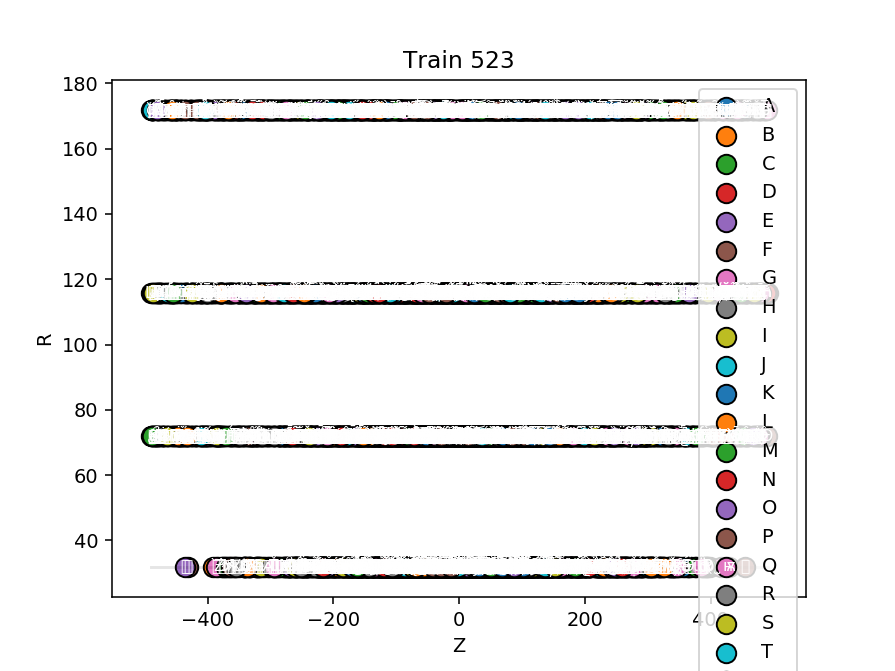

<IPython.core.display.Javascript object>


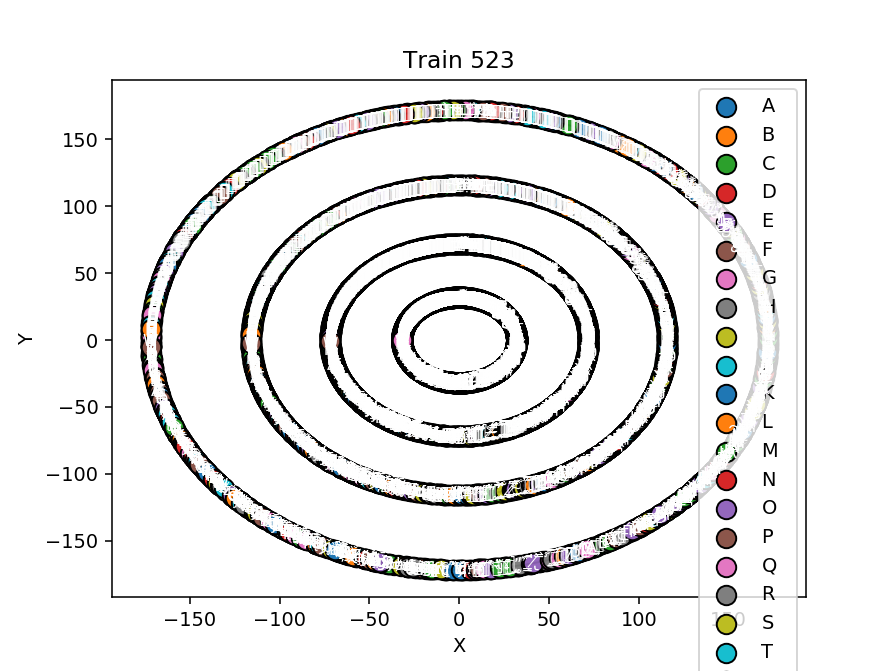

In [12]:
n = np.random.randint(len(train))
print("Train {}".format(n))
print("Number of Hits: {}".format(metrics.number_of_hits(train[n])))
print("Number of Tracks: {}".format(metrics.number_of_tracks(train[n])))
visuals.Plot2D(train[n], order).plot(mode="zr", title="Train {}".format(n))
visuals.Plot2D(train[n], order).plot(mode="xy", title="Train {}".format(n))

In [18]:
visuals.display(train[n], order)

[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


### Create the model.

In [19]:
input_shape  = (11650, 3)
n_categories = 3650 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []

In [ ]:
model = keras.models.load_model(modelpath)

In [20]:
model = Sequential()
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul",
    input_shape=input_shape))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(TimeDistributed(Dense(units=n_categories, kernel_initializer="uniform", activation="softmax")))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 11650, 256)        399360    
_________________________________________________________________
dropout_1 (Dropout)          (None, 11650, 256)        0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 11650, 256)        787968    
_________________________________________________________________
dropout_2 (Dropout)          (None, 11650, 256)        0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 11650, 256)        787968    
_________________________________________________________________
dropout_3 (Dropout)          (None, 11650, 256)        0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 11650, 3652)       938564    
Total para

### Fit the model.

In [22]:
%%time
epochs     = 128
batch_size = 5
histories.append(model.fit_generator(
    ext.input_output_generator(train, batch_size, order),
    steps_per_epoch=len(train) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=ext.input_output_generator(test, batch_size, order),
    validation_steps=len(test) // batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath=modelpath,
            save_best_only=True,
            verbose=0,),
        keras.callbacks.EarlyStopping(patience=10, verbose=1),
        keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1)]))

Epoch 1/128
160/160 [==============================] - 6265s - loss: 5.6135 - acc: 0.2992 - val_loss: 5.3962 - val_acc: 0.3113
Epoch 2/128
 20/160 [==>...........................] - ETA: 5091s - loss: 5.1193 - acc: 0.3002

KeyboardInterrupt: 

### Display information about the model after fitting it.

In [ ]:
%%time
test.sort(key=lambda x: x.iloc[0]["event_id"])
guesses          = model.predict(ext.extract_input(test, order))
hits_correct     = metrics.percent_of_hits_assigned_correctly(test, guesses=guesses, order=order)
tracks_correct   = metrics.percent_of_tracks_assigned_correctly(test, guesses=guesses, order=order, percent=1.0)
n_tracks_correct = metrics.percent_of_events_with_correct_number_of_tracks(test, guesses=guesses, order=order)
print("Percent of hits assigned correctly: {}%".format(hits_correct * 100))
print("Percent of tracks assigned correctly: {}%".format(tracks_correct * 100))
print("Percent of events with the correct number of tracks: {}%".format(n_tracks_correct * 100))

### Display how one of the model's predictions looks.

In [ ]:
n  = 3138  # np.random.randint(len(test))
print("Percent of hits assigned correctly: {}%".format(
    metrics.percent_of_hits_assigned_correctly(test[n], guesses[n], order) * 100))
print("Percent of tracks assigned correctly: {}%".format(
    metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order) * 100))
_ = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="zr", title="Prediction {}".format(n))
_ = visuals.Plot2D(test[n], order).plot(mode="zr", title="Answer {}".format(n))
_ = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="xy", title="Prediction {}".format(n))
_ = visuals.Plot2D(test[n], order).plot(mode="xy", title="Answer {}".format(n))

In [ ]:
visuals.display(test[n], order, guesses[n], mode="discrete pairs")

In [ ]:
%%time
n_tracks, accuracy = metrics.accuracy_vs_tracks(test, guesses, order)
r = range(n_tracks.min(), n_tracks.max() + 1)
boxes = [[] for _ in r]
for i in range(len(n_tracks)):
    boxes[n_tracks[i] - n_tracks.min()].append(accuracy[i])
visuals.boxplot(boxes, "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Discrete Accuracy", xticks=list(r))

In [ ]:
%%time
n_tracks, accuracy = metrics.accuracy_vs_tracks(test, guesses, order)
r = range(n_tracks.min(), n_tracks.max() + 1)
boxes = [[] for _ in r]
for i in range(len(n_tracks)):
    boxes[n_tracks[i] - n_tracks.min()].append(accuracy[i])
visuals.boxplot(boxes, "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Discrete Accuracy", xticks=list(r))

In [ ]:
%%time
for percent in [0.3, 0.5, 0.75, 1.0]:
    c_tracks = [metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order, percent=percent)
                for n in range(len(guesses))]
    boxes = [[] for _ in r]
    for i in range(len(c_tracks)):
        index = metrics.number_of_tracks(test[i]) - 1
        boxes[index].append(c_tracks[i])
    visuals.boxplot(
        boxes, "ACTS-0N-SPLIT-80-20", "Number of Tracks",
        "Percent of Tracks Correctly Assigned ({})".format(percent), xticks=list(r))

In [ ]:
%%time
thresholds = [i / 10 for i in range(11)]
threshold_metrics = [[metrics.threshold_metrics(test[i], guesses[i], n, order)
                      for i in range(len(guesses))] for n in thresholds]
boxes_correct   = [[m[0] for m in metric] for metric in threshold_metrics]
boxes_incorrect = [[m[1] for m in metric] for metric in threshold_metrics]
boxes_multi     = [[m[2] for m in metric] for metric in threshold_metrics]
boxes_none      = [[m[3] for m in metric] for metric in threshold_metrics]
visuals.boxplot(
    boxes_correct, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to correct track]", xticks=thresholds)
visuals.boxplot(
    boxes_incorrect, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to an incorrect track]", xticks=thresholds)
visuals.boxplot(
    boxes_multi, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to multiple tracks]", xticks=thresholds)
visuals.boxplot(
    boxes_none, 
    "ACTS-0N-SPLIT-80-20", "Number of Tracks", "Prob[hit assigned to no tracks]", xticks=thresholds)

In [ ]:
bad_tracks = []
for i in range(len(test)):
    if ext.extract_output(test[i], order)[0, 0] == 1:
        bad_tracks.append(test[i])
bad_guesses = model.predict(ext.extract_input(bad_tracks, order))
print(metrics.percent_of_hits_assigned_correctly(bad_tracks, bad_guesses, order))

In [ ]:
%%time
bend_amounts = [i for i in range(0, 500, 25)]
bends, acc = metrics.accuracy_vs_bend(test, guesses, order, bend_amounts)
visuals.boxplot(
    data   = acc.tolist(),
    fliers = False,
    ylabel = "Probability",
    xlabel = "Bending",
    title  = "Prob[Hit within track belongs to track] vs Track Bend",
    xticks = bends
)

In [ ]:
# %%time
# boxes = [[] for _ in range(30)]
# for i, event in enumerate(test):
#     print(i)
#     crossings    = metrics.number_of_crossings(event)
#     hits_correct = metrics.percent_of_hits_assigned_correctly(event, guesses[i], order) 
#     boxes[crossings].append(hits_correct)
visuals.boxplot(
    data   = boxes[:21],
    fliers =False,
    ylabel = "Probability",
    xlabel = "Crosses",
    title  = "Prob[Hit belongs to right track in event] vs Number of Crossings",
    xticks = [i for i in range(len(boxes))]
)